In [2]:
import numpy as np
from matplotlib import pyplot as plt

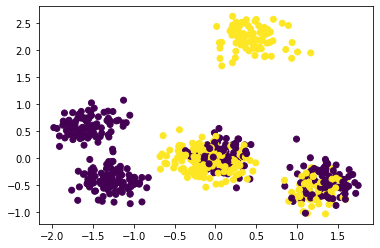

In [3]:
from script import make_dataset
x, y = make_dataset()

Epoch:  0 | train loss: 0.2677
Epoch:  200 | train loss: 0.2475
Epoch:  400 | train loss: 0.2475
Epoch:  600 | train loss: 0.2475
Epoch:  800 | train loss: 0.2475
Epoch:  1000 | train loss: 0.2475
Epoch:  1200 | train loss: 0.2475
Epoch:  1400 | train loss: 0.2475
Epoch:  1600 | train loss: 0.2475
Epoch:  1800 | train loss: 0.2475


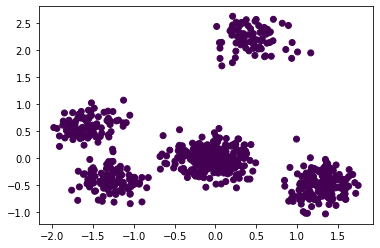

In [4]:
from script import make_model
model = make_model(x, y)

In [5]:
def relu(x):
    x *= x > 0
    return x


class Layer:
    def __init__(self, w, b, abst_func=lambda x: np.floor(relu(x))):
        self.W = w
        self.U = np.array([0 for i in range(self.W.shape[0])]).astype('float64')
        self.b = b
        self.N = self.U.copy()*0
        self.abs_func = abst_func

        self.history_U = [self.U.copy()]
        self.history_S = [self.N.copy()]
        self.history_N = [self.N.copy()]

    def reset(self):
        self.U = self.U*0
        self.N = self.U.copy()

        # self.history_U = [self.U.copy()]
        # self.history_S = [self.N.copy()]
        # self.history_N = [self.N.copy()]

    def forward(self, inp):
        x, spiked = self.simulate(inp)
        self.history_U.append(self.U.copy())
        self.history_S.append(spiked.copy())
        self.history_N.append(self.N.copy())
        # if (self.U>=1).any() and type(self) is Layer: print(self.U)
        return x

    def simulate(self, inp):
        self.U += np.dot(self.W, inp) + self.b
        spiked = self.U >= 1
        return self.neuron_func(spiked), spiked

    def neuron_func(self, spiked):
        if not spiked.any(): return spiked
        self.N += spiked
        self.U[spiked] -= 1
        return spiked

    def abstract_n(self, inp, t, neg_fix=1):
        if len(np.array(inp).shape) == 2:
            return np.array([self.abstract_n(xx, t) for xx in inp])

        if neg_fix: neg_fix=relu(-self.history_U[t])
        if type(self) is OutLayer: neg_fix=0

        return self.abs_func(((np.dot(self.W, inp) + self.b * t + neg_fix)*1).round(4)/1)

    def abstract_v(self, inp, t):
        if len(np.array(inp).shape) == 2:
            return np.array([self.abstract_v(xx, t) for xx in inp])
        return np.dot(self.W, inp) + self.b * t - self.abstract_n(inp, t)

    def plot_history(self, lim, ylim=None):
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.step(np.arange(len(self.history_U)), self.history_U, label='U', where='post')
        plt.scatter(np.arange(len(self.history_S)), np.array(self.history_S).sum(axis=1) * 3 - 2, label='S')
        plt.ylim(-0.1, max(np.max(self.history_U) + 0.1, 1.1))
        plt.xlim(0, lim)
        plt.grid()
        plt.show()

        history_N = [np.array(self.history_S[:tt+1]).sum(axis=0) for tt in range(len(self.history_S))]
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.step(np.arange(len(self.history_S)), np.array(history_N), label='N', where='post')
        if ylim is not None: plt.ylim(-0.1, ylim)
        plt.xlim(0, lim)
        plt.grid()
        plt.show()


class AlterLayer(Layer):
    def neuron_func(self, spiked):
        if not spiked.any(): return spiked
        output = spiked * (self.U // 1)
        self.N += output
        self.U[spiked] %= 1
        return output


class OutLayer(Layer):
    def __init__(self, *args, **kwargs):
        super(OutLayer, self).__init__(abst_func=lambda x: x, *args, **kwargs)

    def neuron_func(self, spiked):
        self.N += self.U.copy()
        self.U = self.U*0
        return self.U.copy()


class SNN:
    def __init__(self, w, b, fin_act=lambda x: x, layer_type=Layer):
        self.layers = [layer_type(w[m], b[m]) for m in range(len(w) - 1)] + [OutLayer(w[-1], b[-1])]
        self.final_activation = fin_act

    def reset(self):
        for l in self.layers: l.reset()

    def __call__(self, x, t=1):
        if len(x.shape) == 1:
            out = self.predict(x, t).copy()
            self.reset()
            return out
        if len(x.shape) != 2: raise ValueError('x must be a vector or 2D matrix')

        out = []
        for i in range(x.shape[0]):
            out.append(self.predict(x[i], t).copy())
            self.reset()
        return np.array(out)

    def forward(self, x):
        layer_out = x.copy()
        for i, l in enumerate(self.layers):
            # print(i, layer_out)
            # if (l.U>=1).any() and type(l) is Layer: print(l.U)
            layer_out = l.forward(layer_out)
        return layer_out

    def predict(self, x, t):
        for _ in range(t): self.forward(x.copy())
        return self.final_activation(self.layers[-1].N / t)

    def abstract_n_layer(self, x, t, lim):
        x = x * t
        for l in self.layers[:lim+1]: x = l.abstract_n(x.copy(), t)
        return x

    def abstract_n(self, x, t):
        return self.final_activation(self.abstract_n_layer(x, t, len(self.layers)) / t)

    def abstract_v_layer(self, x, t, lim):
        x = x * t
        for l in self.layers[:lim]: x = l.abstract_n(x.copy(), t)
        return self.layers[lim].abstract_v(x.copy(), t)

    def abstract_v(self, x, t):
        return self.final_activation(self.abstract_v_layer(x, t, len(self.layers)) / t)

In [6]:
import torch
from script  import get_changed_weight

def get_abs_layer_weight(x, wb, model):
    a = [x.copy()]
    b = [x.copy()]
    p = [x.copy()]
    n = [x.copy()]
    for i in range(len(wb[0])):
        p.append(np.array([np.dot(bb, (wb[0][i]*(wb[0][i]>0)).T)+wb[1][i]*(wb[1][i]>0)
             for bb in b[-1].copy()]))
        a.append(np.array([np.dot(bb,wb[0][i].T)+wb[1][i] for bb in b[-1].copy()]))
        b.append(np.array([aa*(aa>0) for aa in a[-1]]))
        n.append(p[-1]-a[-1])
    b.pop(-1)
    b.append(torch.sigmoid(torch.from_numpy(a[-1].copy()).float()).data.numpy().copy())
    a.pop(0); b.pop(0); p.pop(0); n.pop(0)

    f = lambda x: np.percentile(x.max(),99.9) # np.percentile(abs(x).max(),99.9)
    new_wb = [[wb[0][0]],[wb[1][0]]]
    for l in range(1,len(wb[0])):
        new_wb[0].append(wb[0][l])
        new_wb[1].append(wb[1][l])
        for ne in range(len(wb[0][l])):
            hat=((p[l][ne]/n[l][ne])>1)*((p[l][ne]-n[l][ne])!=1)
            c=(p[l][ne][hat]/n[l][ne][hat])*(f(n[l][ne])/f(p[l][ne]))
            c=c[np.isfinite(c)]
            c=f(c) if c.any() else 1

            new_wb[0][-1][ne][new_wb[0][-1][ne]>0]*=c
            if new_wb[1][-1][ne]>0: new_wb[1][-1][ne]*=c

            new_wb[0][-2][new_wb[0][-1][ne]>0]*=1/c
            new_wb[1][-2][new_wb[1][-1][ne]>0]*=1/c

    return new_wb, (a,b)


In [7]:
w = list(model.parameters())
wb = [[w[i].data.numpy().copy() for i in range(0, len(w), 2)],
      [w[i].data.numpy().copy() for i in range(1, len(w), 2)]]

# wb, (a,b) = get_changed_weight(x,wb,model)
# wb, (a,b) = get_abs_layer_weight(x,wb,model)
# snn_model=SNN(wb[0],wb[1],fin_act=lambda x:1/(1+np.exp(-x)),layer_type=Layer)
snn_model=SNN(wb[0],wb[1],fin_act=lambda x:1/(1+np.exp(-x)),layer_type=AlterLayer)

iii=np.random.choice(x.shape[0])
xx = x.astype('float64')[iii]
t = 2000
print(model(torch.from_numpy(xx.copy()).float()).data.numpy() * 1000//1/1000)
print(snn_model(xx, t) * 1000//1/1000)
print(snn_model.abstract_n(xx, t) * 1000//1/1000)

[0.449 0.55 ]
[0.449 0.55 ]
[0.449 0.55 ]


In [ ]:
dif=[]
for xx in x.astype('float64')[:20]:
    dif.append([])
    for l in snn_model.layers:
        l.history_U = [l.U.copy()]
        l.history_S = [l.N.copy()]
        l.history_N = [l.N.copy()]
    snn_model(xx, t)
    for lay in range(len(snn_model.layers)-1):
        for n in range(len(snn_model.layers[lay].U)):
                real_u=np.array(snn_model.layers[lay].history_N).T[n]
                abs_u=np.array([snn_model.abstract_n_layer(xx,tt,lay) for tt in range(t+1)]).T[n]
                dif[-1].append(abs_u-real_u)
dif=abs(np.array(dif))
np.percentile(dif,99.9)

In [11]:
# from script import plot_n_comparison
# plot_n_comparison(snn_model,xx, t, 1, ylim=1200, xlim=t)#, xmlim=190, ymlim=0

# from script import plot_v_comparison
# plot_v_comparison(snn_model,xx, t, 1, ylim=2, xlim=t)#, xmlim=655, ymlim=-0.5

# from script import plot_delta_comparison
# plot_delta_comparison(snn_model, xx, t, l=1, ylim=1.1, xlim=t, nnn=True)